<a href="https://colab.research.google.com/github/dkaratzas/DL2022-23/blob/main/Problems%207%20-%20Autoencoders/P7_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%207%20-%20Autoencoders/P7_Autoencoders.ipynb)

# Autoencoders

In this notebook we will explore three different types of autoencoder architectures: Simple MLP Autoencoder, Convolutional Autoencoder and Variational Autoencoder (VAE). We will also see how we can use VAEs to generate new data.

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

# Setting up

In [2]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def show_image(img):
    img = img.clamp(0, 1) # Ensure that the range of greyscales is between 0 and 1
    npimg = img.numpy()   # Convert to NumPy
    npimg = np.transpose(npimg, (2, 1, 0))   # Change the order to (W, H, C)
    plt.imshow(npimg)
    plt.show()

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2
)

100%|██████████| 9912422/9912422 [00:00<00:00, 228424168.01it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 86463735.78it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 86596939.72it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5734656.46it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
image_tensor,label = train_dataset[33]
print(torch.min(image_tensor))
print(torch.max(image_tensor))

tensor(0.)
tensor(1.)


# Simple Autoencoder

We will define a simple MLP Autoencoder

In [6]:
class AE(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
model = AE(input_size=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

Define the training and testing loops

In [8]:
def train(model, loader, optimizer, criterion, reshape=False):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

def test(model, loader, criterion, reshape=False):
    loss = 0
    model.eval()

    for batch_features, _ in loader:
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs = model(batch_features)

        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features)

        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()

    # compute the epoch test loss
    loss = loss / len(loader)

    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch : 1/10, Train loss = 0.051125
epoch : 1/10, Test loss = 0.027062


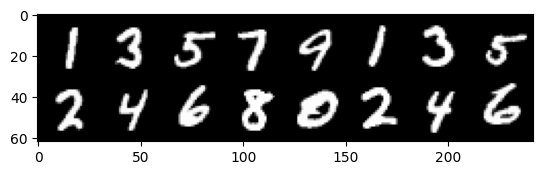

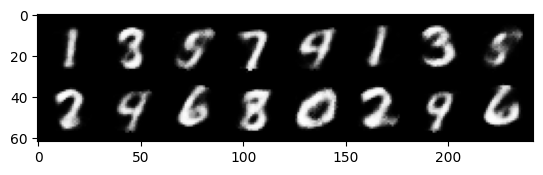

epoch : 2/10, Train loss = 0.021785
epoch : 2/10, Test loss = 0.017440


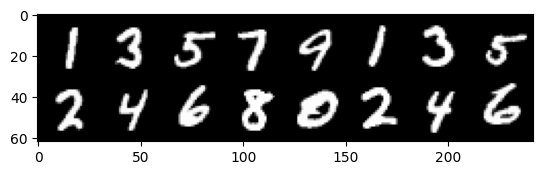

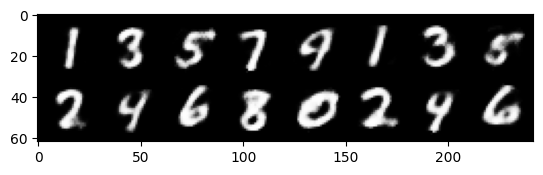

epoch : 3/10, Train loss = 0.015995
epoch : 3/10, Test loss = 0.013876


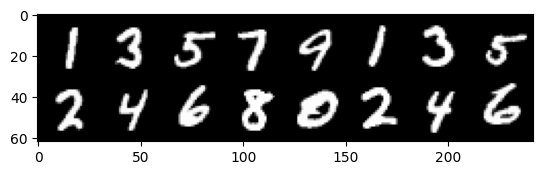

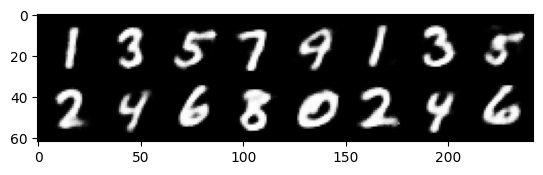

epoch : 4/10, Train loss = 0.013249
epoch : 4/10, Test loss = 0.011793


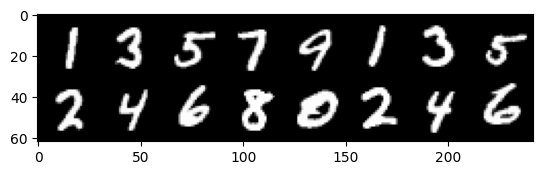

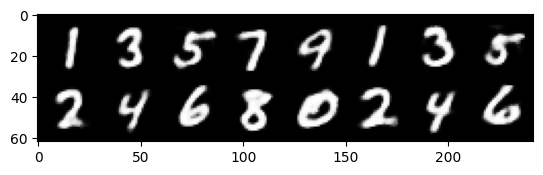

epoch : 5/10, Train loss = 0.011489
epoch : 5/10, Test loss = 0.010484


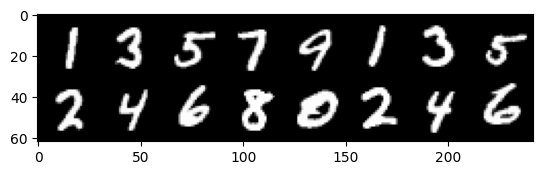

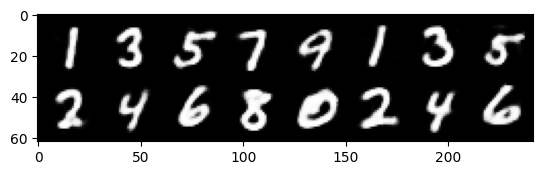

epoch : 6/10, Train loss = 0.010247
epoch : 6/10, Test loss = 0.009395


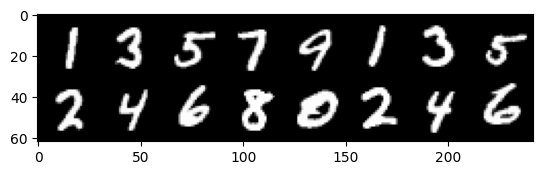

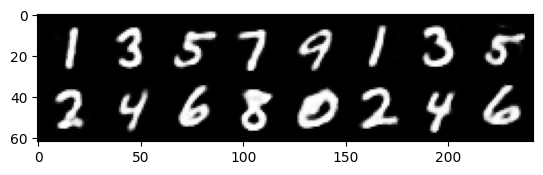

epoch : 7/10, Train loss = 0.009240
epoch : 7/10, Test loss = 0.008507


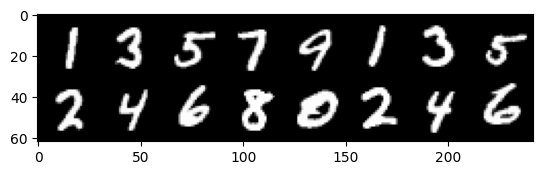

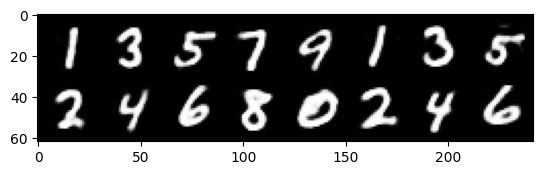

epoch : 8/10, Train loss = 0.008475
epoch : 8/10, Test loss = 0.007810


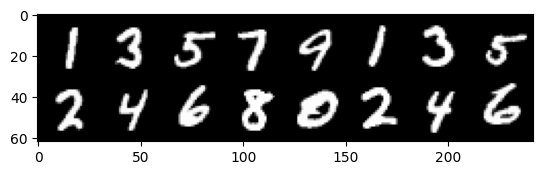

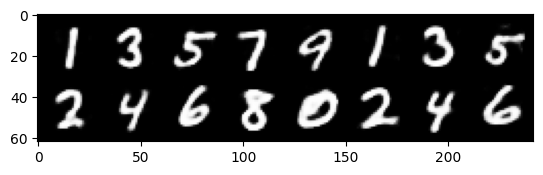

epoch : 9/10, Train loss = 0.007915
epoch : 9/10, Test loss = 0.007382


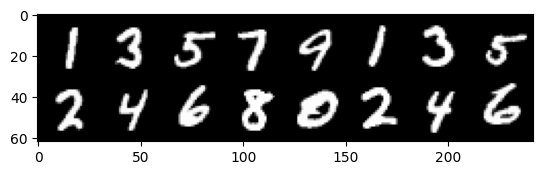

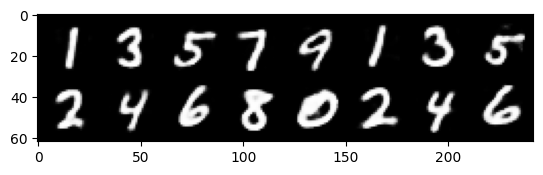

epoch : 10/10, Train loss = 0.007428
epoch : 10/10, Test loss = 0.007046


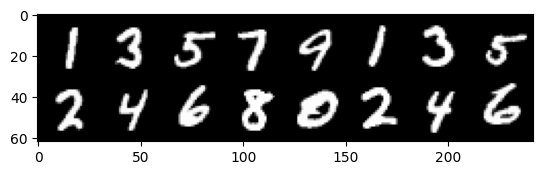

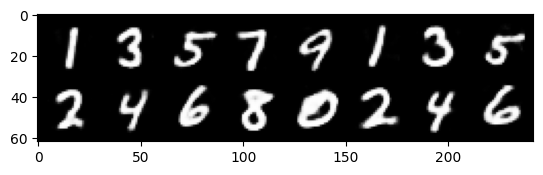

In [9]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=True)
    test(model, test_loader, criterion, reshape=True)

# Convolutional Autoencoder

We will now build a convolutional Autoencoder. Below you can find an incomplete implementation of one (only the encoder part)...

In [24]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(

            # THIS PART IS MISSING...
            nn.ConvTranspose2d(8, 16, 3, stride=2), #b,16,5,5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1), #b,8,15,15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1), #b,1,28,28
            nn.Sigmoid()

        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

<span style="color:blue">

Let's build the decoder for the convolutional autoencoder model above and train it using the same functions and hyper-parameters as defined above.

> We use only deconvolutions (design an non-symmetric architecture) so that we do not have to store indices for the unpooling layers. Have a look at `ConvTranspose2d()` https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

    
> To calculate the new activation map's size while deconvolving we should use: $𝑛^{[𝑙]} =(𝑛^{[𝑙−1]}−1) 𝑠 − 2𝑝 + 𝑓$
    
</span>

epoch : 1/10, Train loss = 0.098888
epoch : 1/10, Test loss = 0.077962


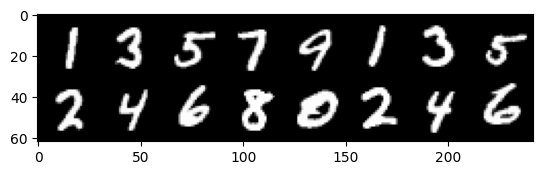

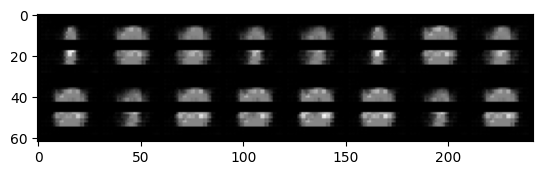

epoch : 2/10, Train loss = 0.070396
epoch : 2/10, Test loss = 0.055914


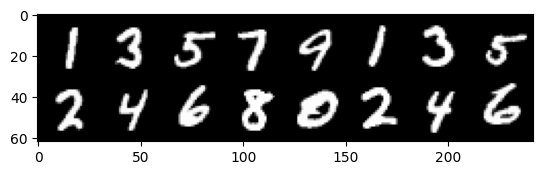

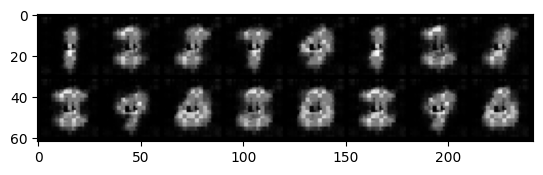

epoch : 3/10, Train loss = 0.046446
epoch : 3/10, Test loss = 0.041596


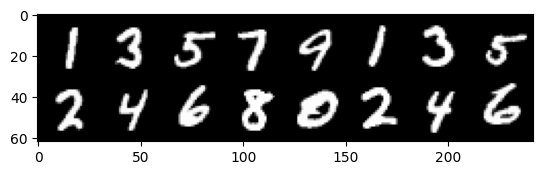

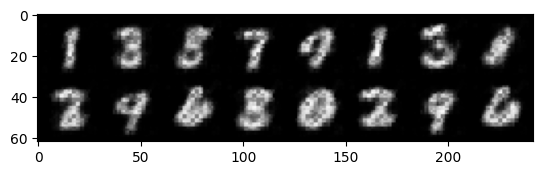

epoch : 4/10, Train loss = 0.039574
epoch : 4/10, Test loss = 0.037427


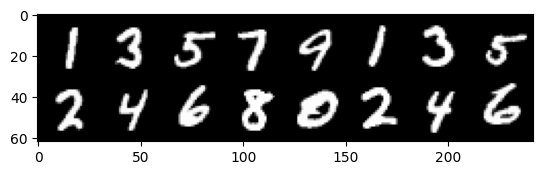

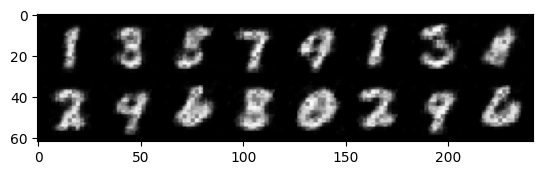

epoch : 5/10, Train loss = 0.036576
epoch : 5/10, Test loss = 0.035069


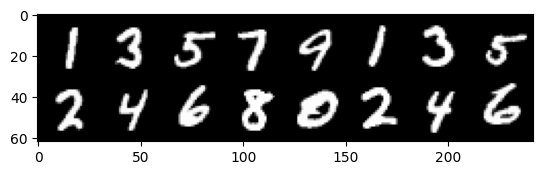

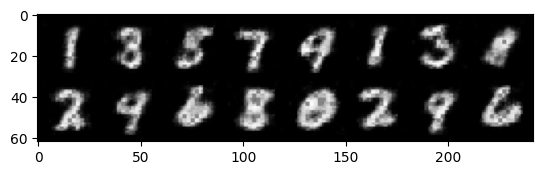

epoch : 6/10, Train loss = 0.034733
epoch : 6/10, Test loss = 0.033563


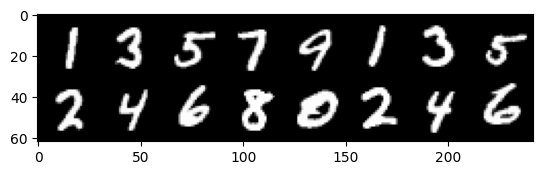

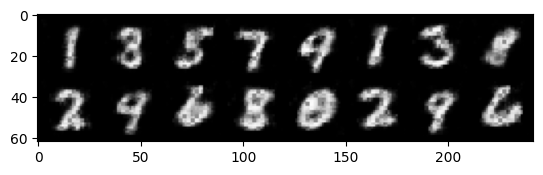

epoch : 7/10, Train loss = 0.033493
epoch : 7/10, Test loss = 0.032487


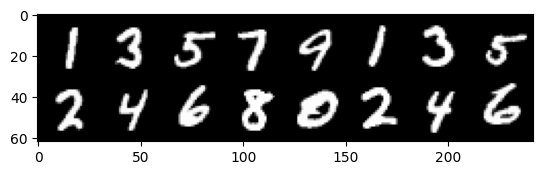

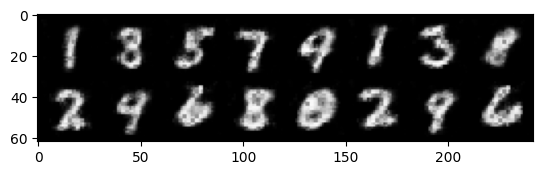

epoch : 8/10, Train loss = 0.032569
epoch : 8/10, Test loss = 0.031729


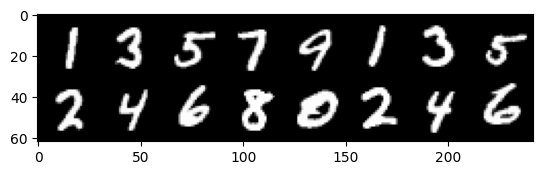

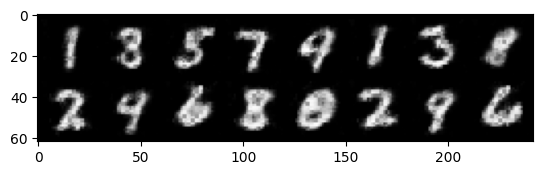

epoch : 9/10, Train loss = 0.031819
epoch : 9/10, Test loss = 0.030969


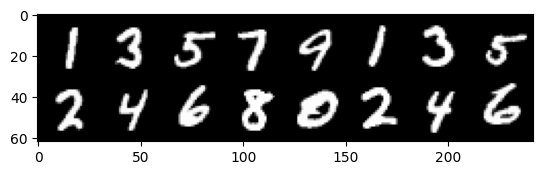

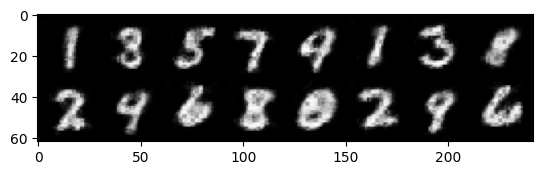

epoch : 10/10, Train loss = 0.031174
epoch : 10/10, Test loss = 0.030346


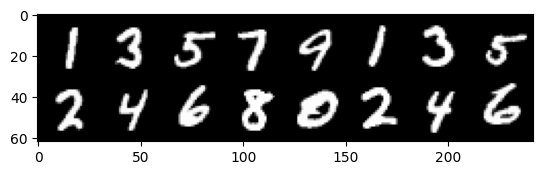

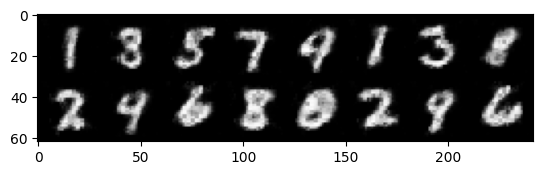

In [11]:
model_conv = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model_conv.parameters(), lr=1e-3)

epochs=10
for epoch in range(epochs):
    train(model_conv, train_loader, optimizer, criterion, reshape=False)
    test(model_conv, test_loader, criterion, reshape=False)

<span style="color:blue">

**Exercise 2 (HOMEWORK)**: Rebuild the network, but this time do a symmetric design for the decoder (using unpooling as required) and train it using the same functions and hyper-parameters as defined above.

> Hint: Have a look at `MaxUnpool2d()` https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html
    
</span>

In [26]:
# Your Code Here
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        #encoder
        self.conv1= nn.Conv2d(1, 16, 3, stride=3, padding=1)  # b, 16, 10, 10
        self.ReLU= nn.ReLU()
        self.pool1= nn.MaxPool2d(2, stride=2,return_indices=True)  # b, 16, 5, 5
        self.conv2= nn.Conv2d(16, 8, 3, stride=2, padding=1)  # b, 8, 3, 3
        #self.ReLU= nn.ReLU()
        self.pool2= nn.MaxPool2d(2, stride=1,return_indices=True)  # b, 8, 2, 2

        #decoder
        self.unpool2= nn.MaxUnpool2d(2,stride=1) #b, 8, 3, 3
        self.deconv2= nn.ConvTranspose2d(8,16,3,stride=2,padding=1) # b, 16, 5, 5
        #self.ReLU()=nn.ReLU()
        self.unpool1= nn.MaxUnpool2d(2,stride=2) # b, 16, 10, 10
        self.deconv1= nn.ConvTranspose2d(16, 1, 3, stride=3, padding=1) # b, 1, 28, 28
        self.Sigmoid= nn.Sigmoid()


    def forward(self, x):
        #encode
        x = self.conv1(x)
        x = self.ReLU(x)
        x, ind1 = self.pool1(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x, ind2 = self.pool2(x)

        #decode
        x = self.unpool2(x,ind2)
        x = self.deconv2(x)
        x = self.ReLU(x)
        x = self.unpool1(x,ind1)
        x = self.deconv1(x)
        x = self.Sigmoid(x)
        return x

epoch : 1/10, Train loss = 0.205161
epoch : 1/10, Test loss = 0.144382


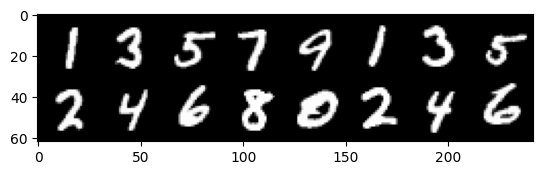

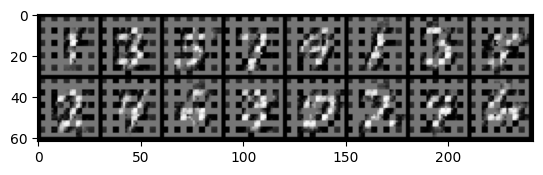

epoch : 2/10, Train loss = 0.119369
epoch : 2/10, Test loss = 0.100039


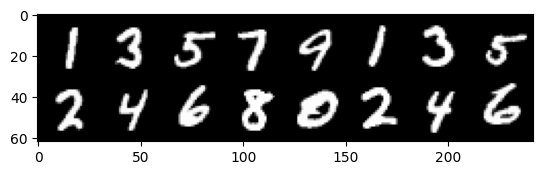

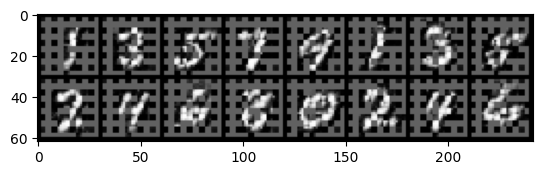

epoch : 3/10, Train loss = 0.086695
epoch : 3/10, Test loss = 0.075455


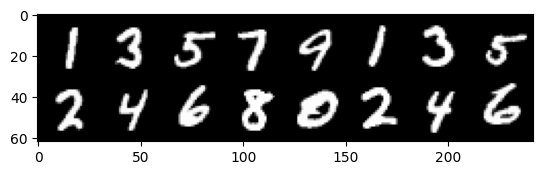

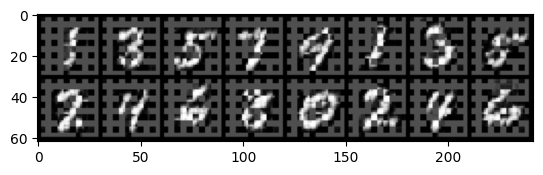

epoch : 4/10, Train loss = 0.066547
epoch : 4/10, Test loss = 0.058990


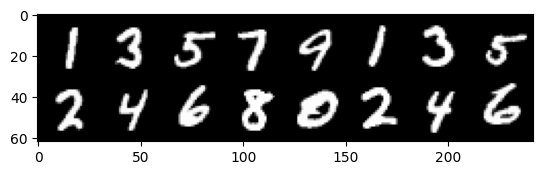

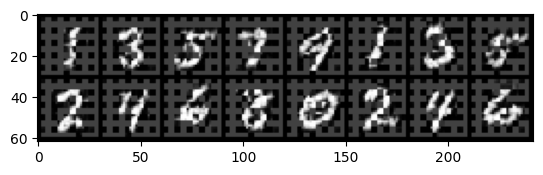

epoch : 5/10, Train loss = 0.053198
epoch : 5/10, Test loss = 0.048419


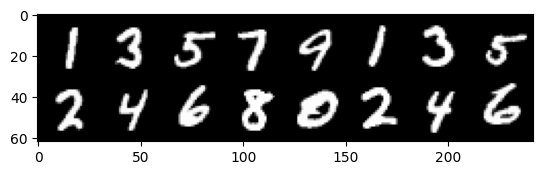

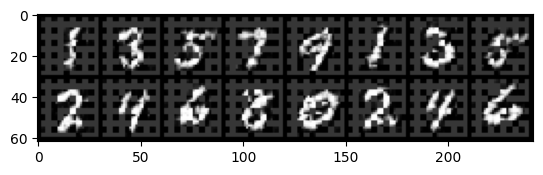

epoch : 6/10, Train loss = 0.044408
epoch : 6/10, Test loss = 0.041275


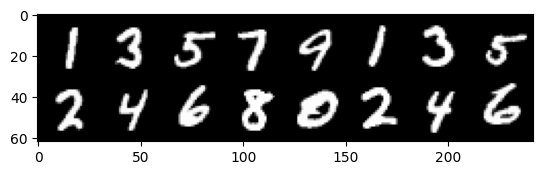

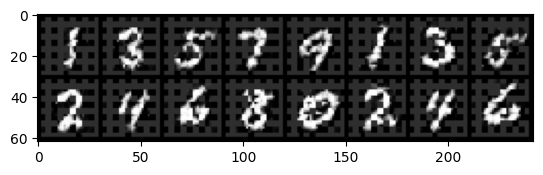

epoch : 7/10, Train loss = 0.038743
epoch : 7/10, Test loss = 0.036764


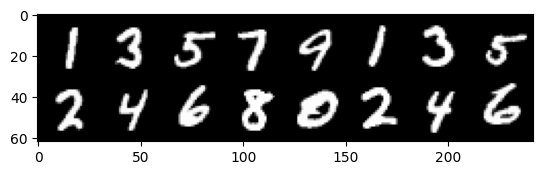

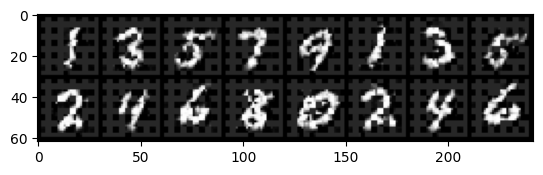

epoch : 8/10, Train loss = 0.034413
epoch : 8/10, Test loss = 0.032965


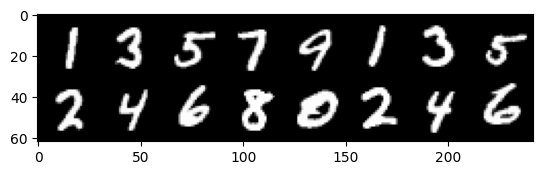

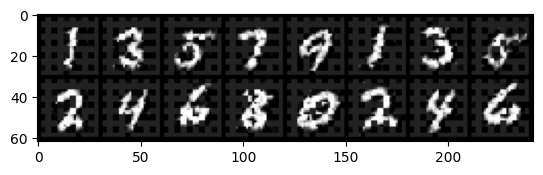

epoch : 9/10, Train loss = 0.031517
epoch : 9/10, Test loss = 0.030565


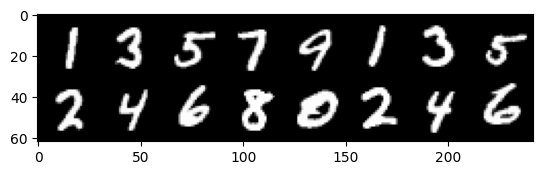

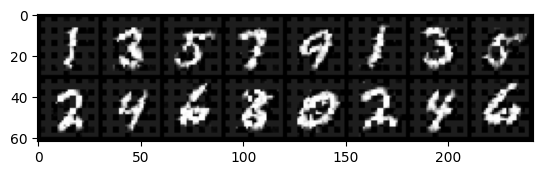

epoch : 10/10, Train loss = 0.029540
epoch : 10/10, Test loss = 0.028905


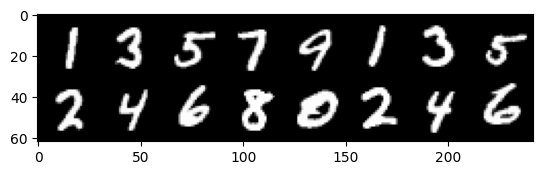

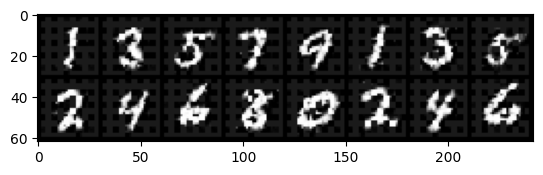

In [12]:
model_conv2 = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model_conv2.parameters(), lr=1e-3)

epochs=10
for epoch in range(epochs):
    train(model_conv2, train_loader, optimizer, criterion, reshape=False)
    test(model_conv2, test_loader, criterion, reshape=False)

# Variational Autoencoders (VAEs)

Below we define a variational autoencoder. It takes a vector of 784 elements, and maps it into a mean and a `logvar` of size 20.

Note that `logvar` corresponds to $ln(\sigma^2)$.

In [12]:
class VAE(nn.Module):
    def __init__(self,latent_size):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        self.fc3 = nn.Linear(latent_size, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In the case of the VAE, we need to define our own loss function, as we need to combine the reconstruction loss, with the regularisation term (Gaussian prior for the embedding distribution).

> *NOTE: You will see that we use an MSE loss as a reconstruction loss, instead of the negative log likelihood that we should be using... this actually makes sense. We have designed this model so that the output of the decoder is the image - the pixel values (means) and not distributions over the pixel values (e.g. means and variances of a Gaussian).*

> *This is typical in VAE implementations; the output of the decoder is actually the mean $\mu_{x|z}$ (let's just call it $\mu$) and we usually assumes a unitary covariance. So in that case we have: $log(P(x|z))=-{\frac 1 2}[log(|Σ|)+k log(2\pi)+(x−\mu)^T(x−\mu)]$*

> *This comes from taking the log of the probability density function of a multivariate Gaussian distribution. Now you can see that since the first two terms are constant with respect to $\mu$, the optimization problem is equivalent to maximizing $-{\frac 1 2}(x−\mu)^T(x−\mu)$ which is the just the L2 loss between $x$ and $\mu$. Finally the expectation is just approximated by averaging.*

In [13]:
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    # Reconstruction term
    recLoss = nn.MSELoss(reduction='sum')

    # KL divergence regularisation term
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recLoss(recon_x, x) + KLD

In [14]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(20).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = loss_function

In [15]:
def train_vae(model, loader, optimizer, criterion):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions as well as the embeddings (we need them for the loss)
        outputs, mu, logvar = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features, mu, logvar)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))


def test_vae(model, loader, criterion):
    loss = 0
    model.eval()

    for batch_features, _ in loader:
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs, mu, logvar = model(batch_features)

        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features, mu, logvar)

        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()

    # compute the epoch test loss
    loss = loss / len(loader)

    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))

<ipython-input-12-f642eef25638>:19: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  eps = torch.cuda.FloatTensor(std.size()).normal_()


epoch : 1/10, Train loss = 5873.643771
epoch : 1/10, Test loss = 1171.296940


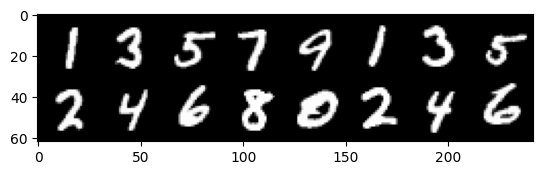

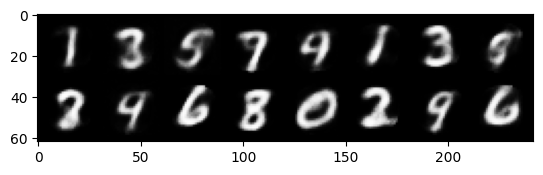

epoch : 2/10, Train loss = 4491.533345
epoch : 2/10, Test loss = 1073.477398


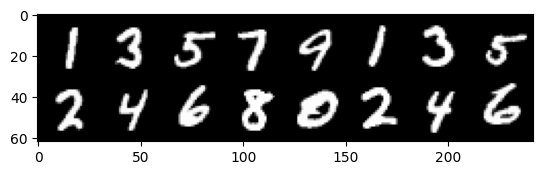

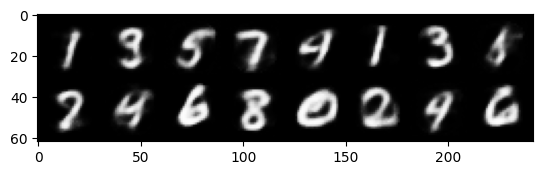

epoch : 3/10, Train loss = 4248.207724
epoch : 3/10, Test loss = 1033.233762


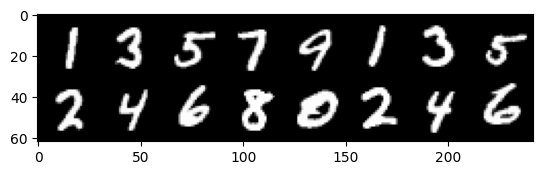

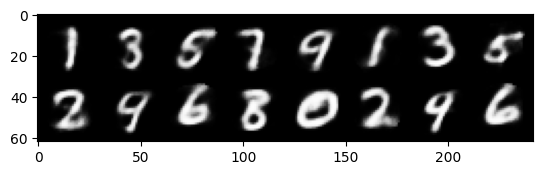

epoch : 4/10, Train loss = 4128.979482
epoch : 4/10, Test loss = 1015.010824


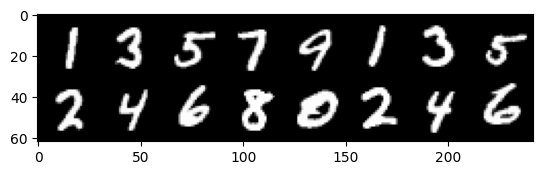

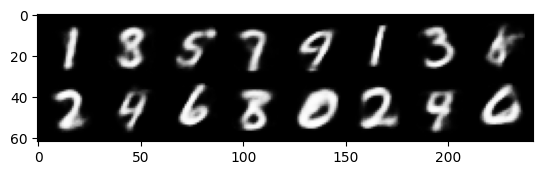

epoch : 5/10, Train loss = 4061.333845
epoch : 5/10, Test loss = 1002.504673


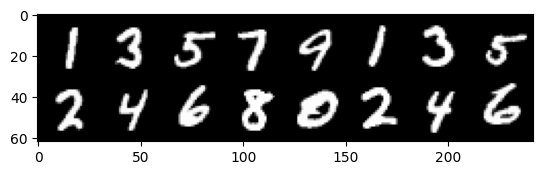

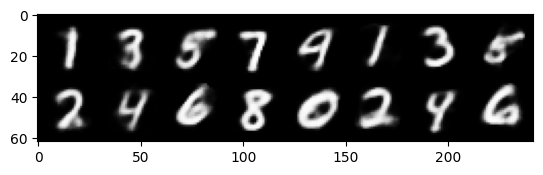

epoch : 6/10, Train loss = 4018.393162
epoch : 6/10, Test loss = 991.646597


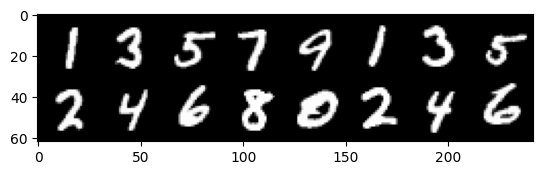

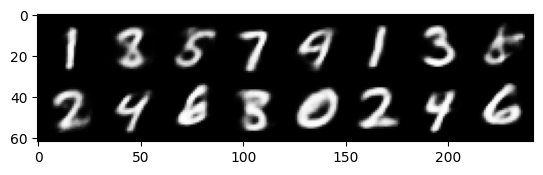

epoch : 7/10, Train loss = 3982.542380
epoch : 7/10, Test loss = 984.836922


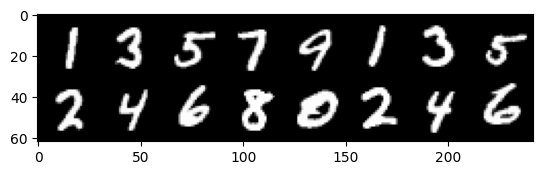

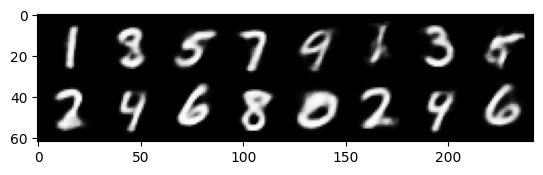

epoch : 8/10, Train loss = 3959.965079
epoch : 8/10, Test loss = 979.000358


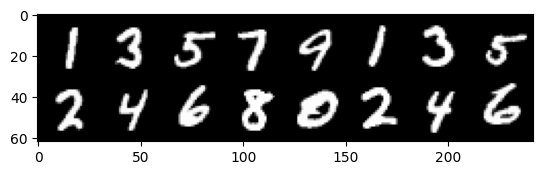

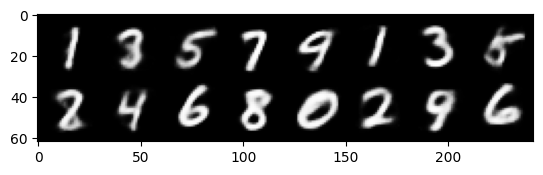

epoch : 9/10, Train loss = 3941.492272
epoch : 9/10, Test loss = 978.894382


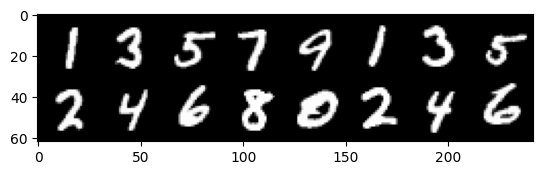

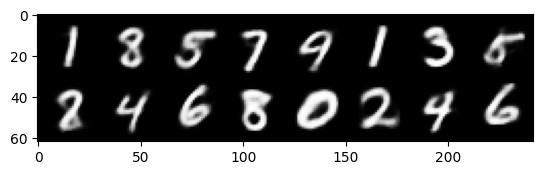

epoch : 10/10, Train loss = 3922.636809
epoch : 10/10, Test loss = 969.347542


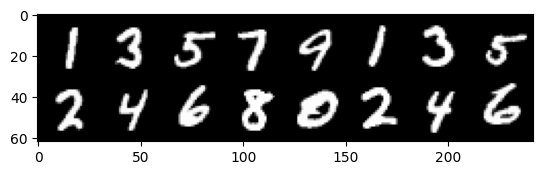

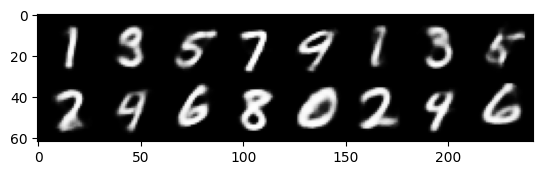

In [16]:
epochs=10
for epoch in range(epochs):
    train_vae(model, train_loader, optimizer, criterion)
    test_vae(model, test_loader, criterion)

We can now use our variational autoencoder to generate new digits. Below we select two digits, and we interpolate between their embeddings to generate embeddings on the line connecting the two original digits. Then we plot them - you should be able to see an evolution from one to the other.

In [17]:
model.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        #img1 = img1.view(img1.size(0), -1).to(device)
        img1 = img1.view(-1, 784).to(device)
        latent_1, _ = model.encode(img1)

        # latent vector of second image
        #img2 = img2.view(img2.size(0), -1).to(device)
        img2 = img2.view(-1, 784).to(device)
        latent_2, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = (1-lambda1) * latent_1 + lambda1 * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image


def visualize_interpolation(model, test_dataloader, digit1 = 7, digit2 = 1):
    # sort part of test set by digit
    digits = [[] for _ in range(10)] # an empty structure to keep samples corresponding to the different digits

    for img_batch, label_batch in test_dataloader:
        for i in range(img_batch.size(0)):
            digits[label_batch[i]].append(img_batch[i:i+1])
        if sum(len(d) for d in digits) >= 1000: # stop when we reach 1000 digits
            break;

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10) # Get 10 points between 0 and 1
    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), model, digits[digit1][0], digits[digit2][0])

        inter_image = inter_image.view(1, 28, 28)

        image = inter_image.numpy()
        axs[ind].imshow(image[0,:,:], cmap='gray')
        axs[ind].set_title('lambda_val='+str(round(l,1)))
    plt.show()

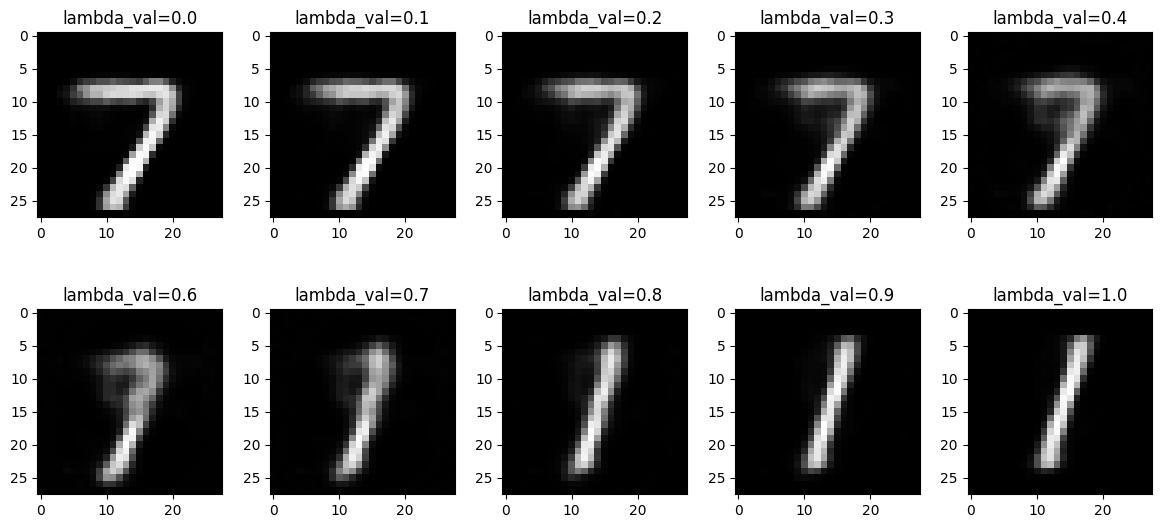

In [18]:
visualize_interpolation(model, test_loader, 7, 1)

<span style="color:blue">

Let'S use the already trained VAE model to generate 100 random new digits.
    
</span>

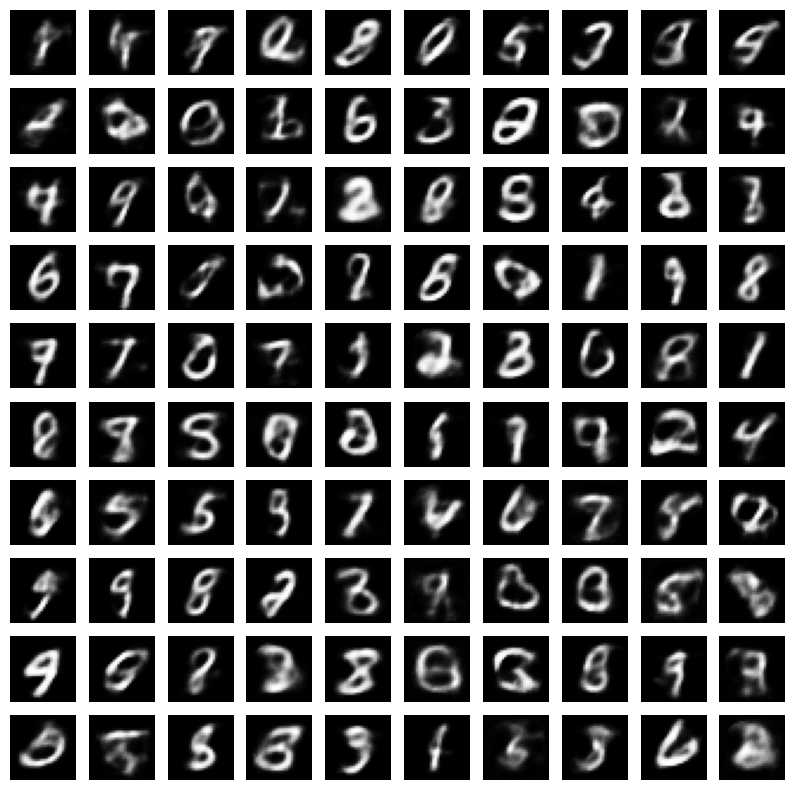

In [19]:

latent_size = 20
random_latent_vectors = torch.randn(100, 20).to(device)

with torch.no_grad():
    images = model.decode(random_latent_vectors)

images = images.view(100, 28, 28).cpu().numpy()

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i], cmap= "gray")
    ax.axis("off")

plt.show()

<span style="color:blue">

Let's modify the VAE model so that it creates a 2-dimensional latent space. Train it on MNIST and then complete the cell below to visualize the entire 2D latent space.
    
</span>

epoch : 1/10, Train loss = 6315.407400
epoch : 1/10, Test loss = 1392.635809


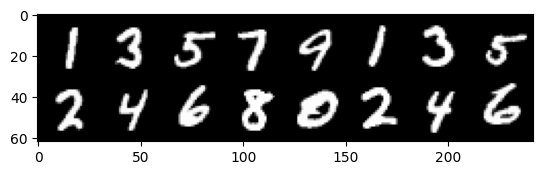

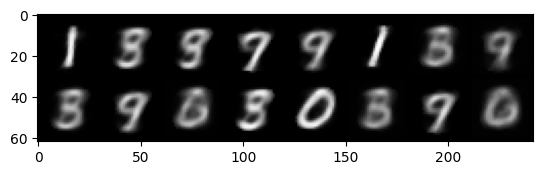

epoch : 2/10, Train loss = 5472.387437
epoch : 2/10, Test loss = 1342.820752


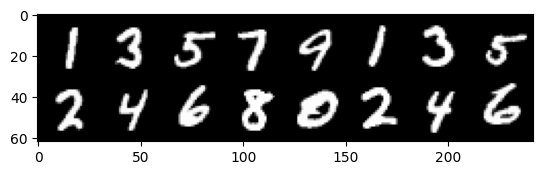

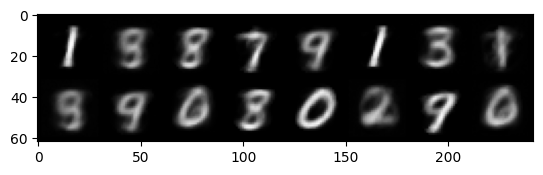

epoch : 3/10, Train loss = 5317.475076
epoch : 3/10, Test loss = 1307.614157


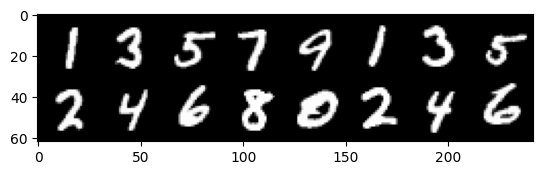

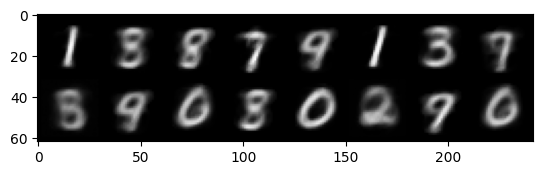

epoch : 4/10, Train loss = 5223.582235
epoch : 4/10, Test loss = 1291.592082


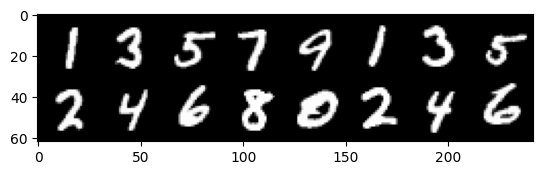

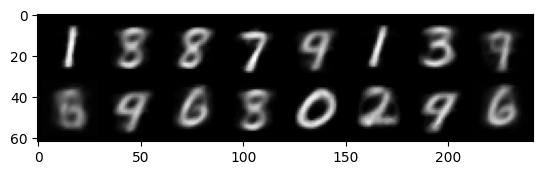

epoch : 5/10, Train loss = 5160.347386
epoch : 5/10, Test loss = 1281.827574


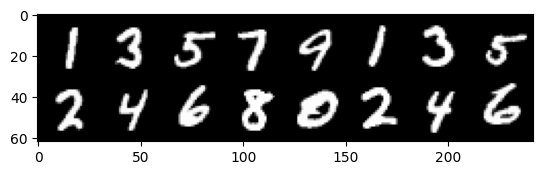

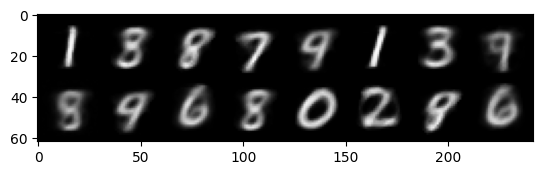

epoch : 6/10, Train loss = 5112.277133
epoch : 6/10, Test loss = 1273.703507


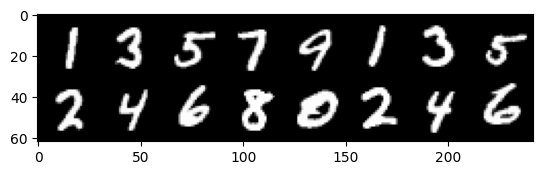

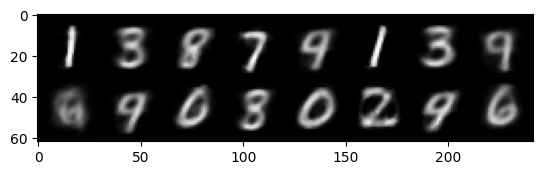

epoch : 7/10, Train loss = 5073.046591
epoch : 7/10, Test loss = 1263.743006


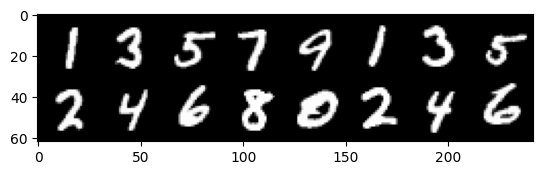

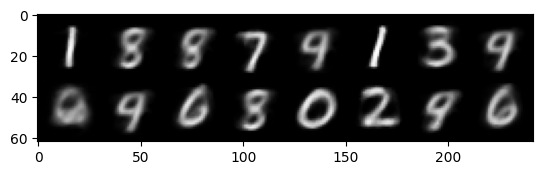

epoch : 8/10, Train loss = 5044.049912
epoch : 8/10, Test loss = 1260.767007


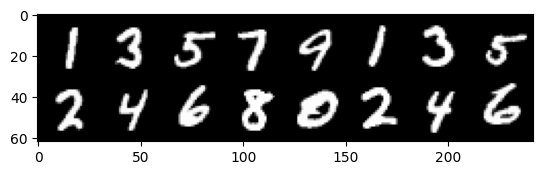

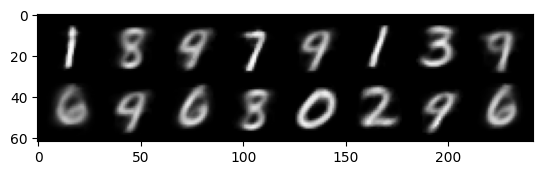

epoch : 9/10, Train loss = 5015.933997
epoch : 9/10, Test loss = 1251.294487


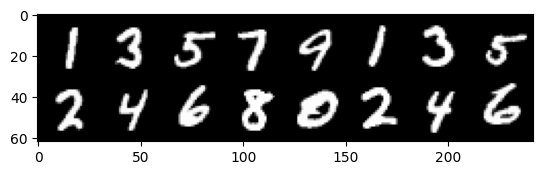

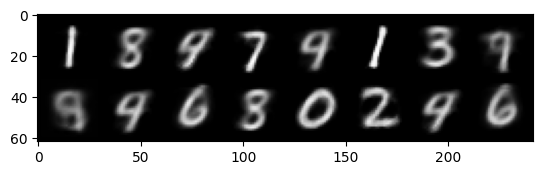

epoch : 10/10, Train loss = 4989.406997
epoch : 10/10, Test loss = 1253.666062


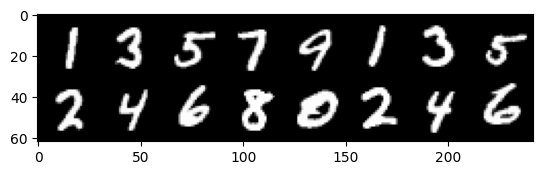

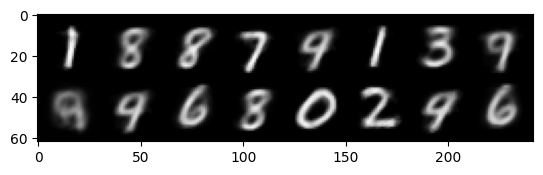

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_2 = VAE(2).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)

criterion = loss_function

epochs=10
for epoch in range(epochs):
    train_vae(model_2, train_loader, optimizer, criterion)
    test_vae(model_2, test_loader, criterion)

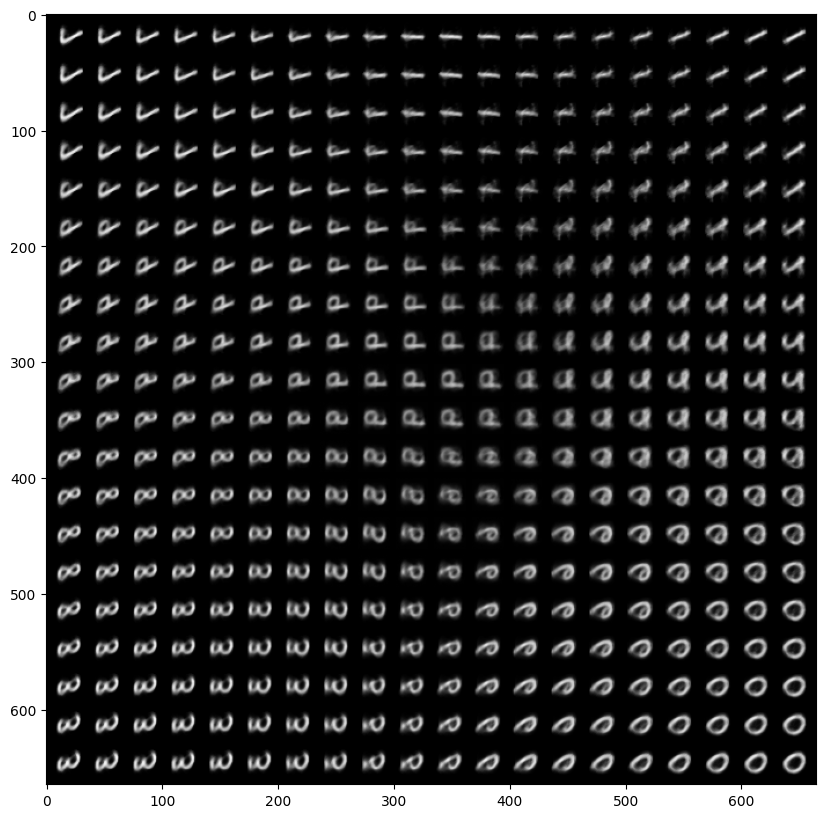

In [33]:
with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2).to(device) # flatten grid into a batch

    # reconstruct images from the latent vectors
    # Your code here
    image_recon = model_2.decode(latents)

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.cpu().view(-1, 1, 28, 28),20,5))
    plt.show()

<span style="color:blue">

We try both the simple encoder and the convolutional encoder with the FashionMNIST dataset.
    
</span>

In [22]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader_FMNIST = torch.utils.data.DataLoader(
    train_dataset_FMNIST, batch_size=128, shuffle=True, num_workers=2#, pin_memory=True
)

test_loader_FMNIST = torch.utils.data.DataLoader(
    test_dataset_FMNIST, batch_size=32, shuffle=False, num_workers=2
)

100%|██████████| 26421880/26421880 [00:00<00:00, 113192207.76it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 17428534.78it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 67517901.28it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24481039.67it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch : 1/10, Train loss = 0.037982
epoch : 1/10, Test loss = 0.021979


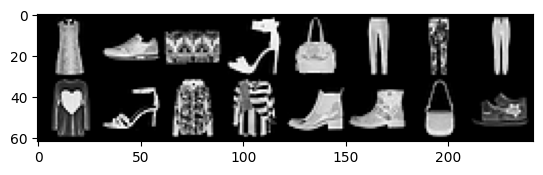

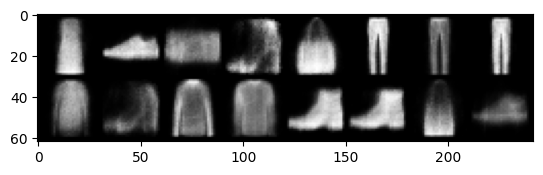

epoch : 2/10, Train loss = 0.019596
epoch : 2/10, Test loss = 0.017885


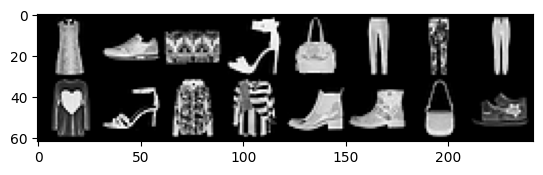

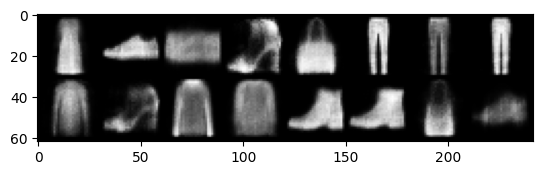

epoch : 3/10, Train loss = 0.016807
epoch : 3/10, Test loss = 0.015871


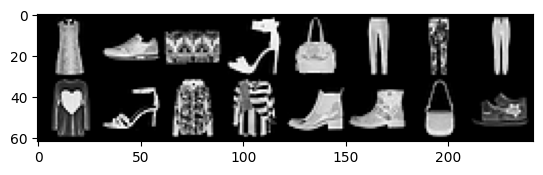

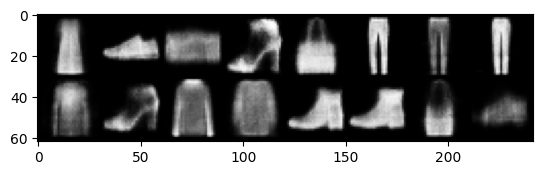

epoch : 4/10, Train loss = 0.015077
epoch : 4/10, Test loss = 0.014396


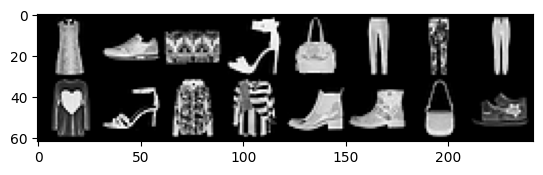

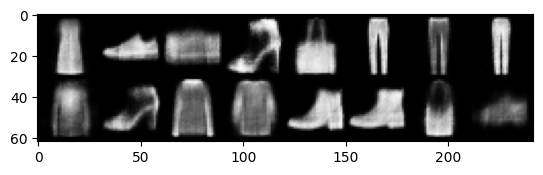

epoch : 5/10, Train loss = 0.013833
epoch : 5/10, Test loss = 0.013472


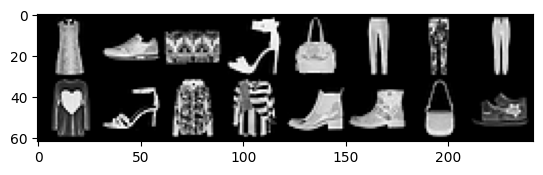

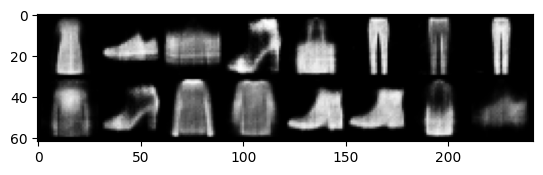

epoch : 6/10, Train loss = 0.012925
epoch : 6/10, Test loss = 0.012718


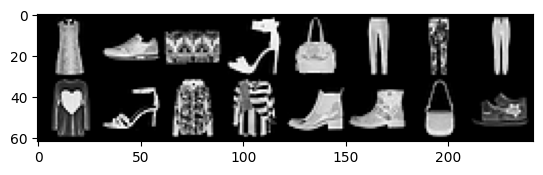

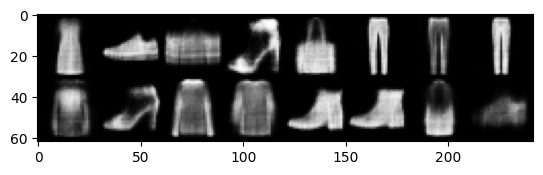

epoch : 7/10, Train loss = 0.012255
epoch : 7/10, Test loss = 0.012066


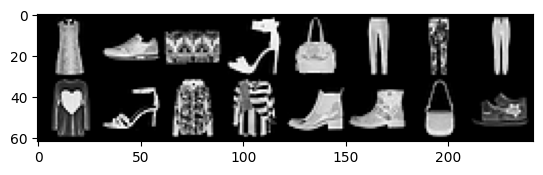

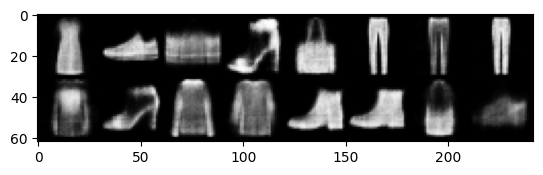

epoch : 8/10, Train loss = 0.011710
epoch : 8/10, Test loss = 0.011547


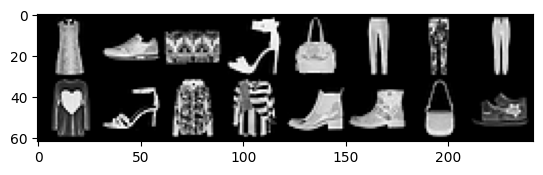

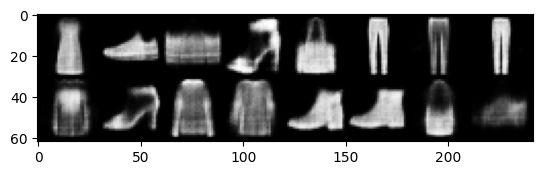

epoch : 9/10, Train loss = 0.011286
epoch : 9/10, Test loss = 0.011275


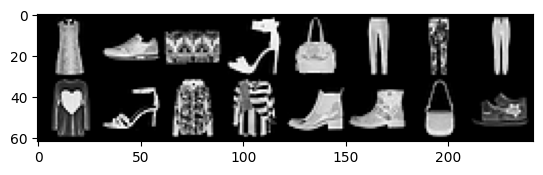

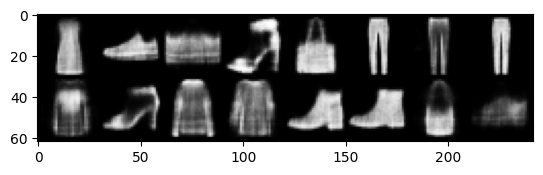

epoch : 10/10, Train loss = 0.010878
epoch : 10/10, Test loss = 0.010821


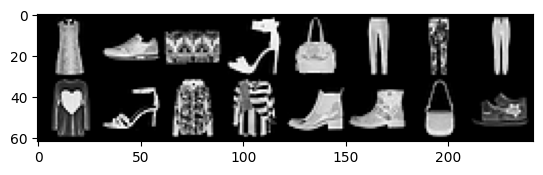

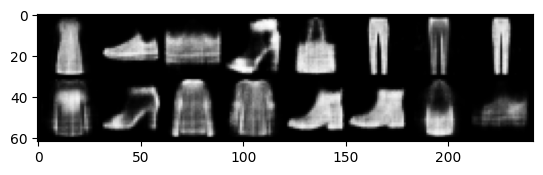

In [36]:
model_e = AE(input_size=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model_e.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epochs=10
for epoch in range(epochs):
    train(model_e, train_loader_FMNIST, optimizer, criterion, reshape=True)
    test(model_e, test_loader_FMNIST, criterion, reshape=True)

epoch : 1/10, Train loss = 0.120898
epoch : 1/10, Test loss = 0.093616


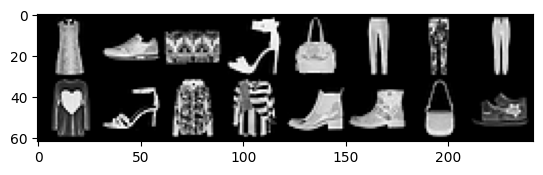

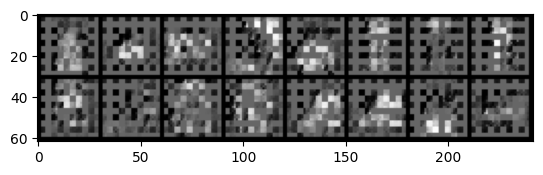

epoch : 2/10, Train loss = 0.087538
epoch : 2/10, Test loss = 0.082126


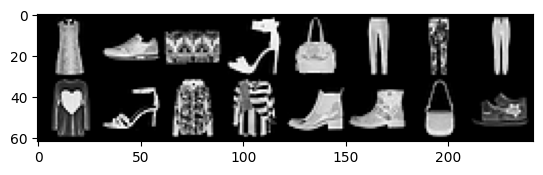

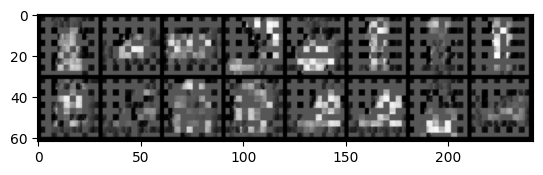

epoch : 3/10, Train loss = 0.078949
epoch : 3/10, Test loss = 0.075123


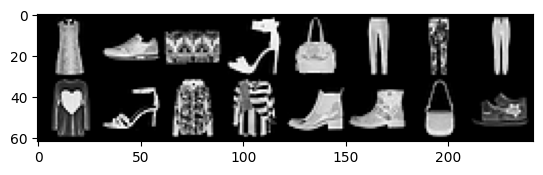

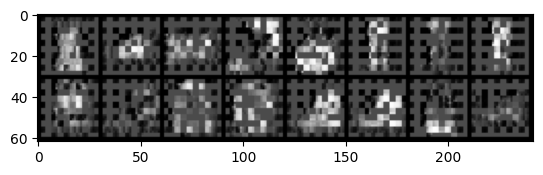

epoch : 4/10, Train loss = 0.072502
epoch : 4/10, Test loss = 0.069237


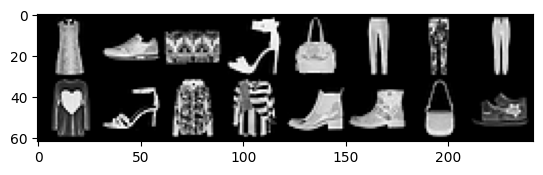

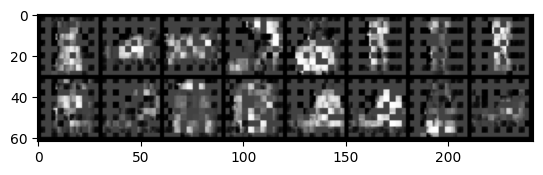

epoch : 5/10, Train loss = 0.067235
epoch : 5/10, Test loss = 0.064728


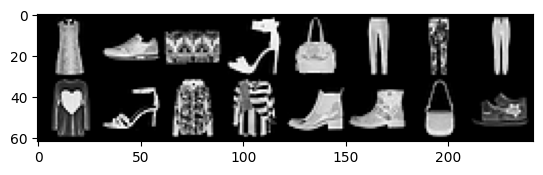

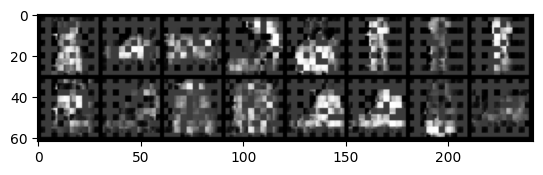

epoch : 6/10, Train loss = 0.063209
epoch : 6/10, Test loss = 0.061253


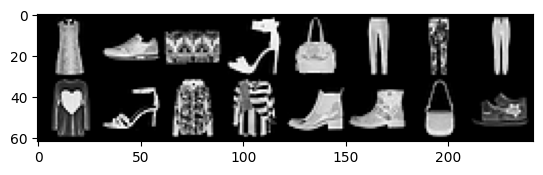

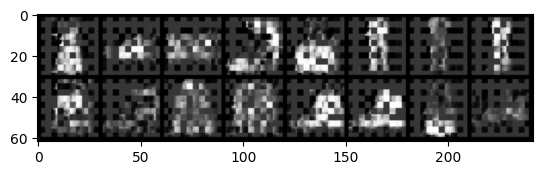

epoch : 7/10, Train loss = 0.060092
epoch : 7/10, Test loss = 0.059029


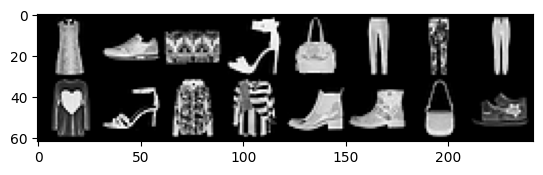

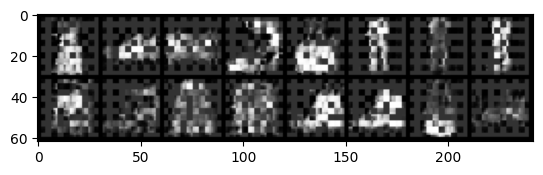

epoch : 8/10, Train loss = 0.058853
epoch : 8/10, Test loss = 0.058484


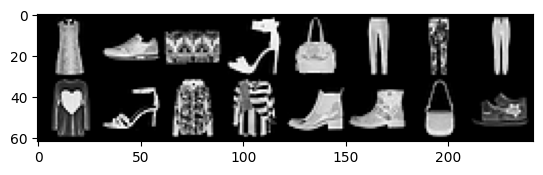

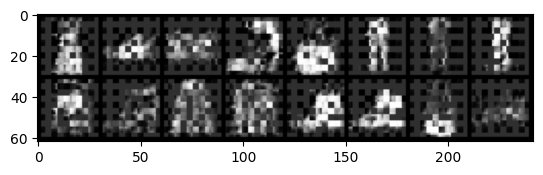

epoch : 9/10, Train loss = 0.058180
epoch : 9/10, Test loss = 0.057392


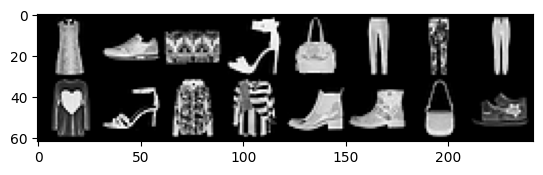

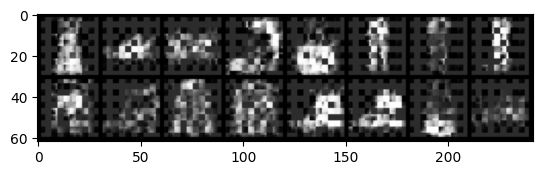

epoch : 10/10, Train loss = 0.057241
epoch : 10/10, Test loss = 0.056884


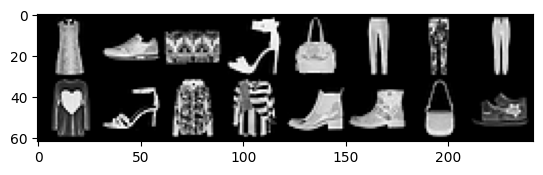

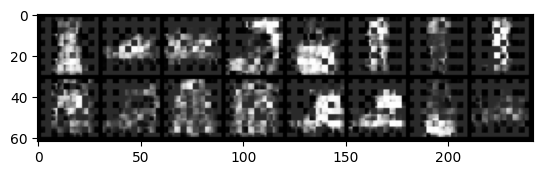

In [27]:
model_conv_f = ConvAE().to(device)


optimizer = torch.optim.Adam(model_conv_f.parameters(), lr=1e-3)

criterion = nn.MSELoss()
epochs=10
for epoch in range(epochs):
    train(model_conv_f, train_loader_FMNIST, optimizer, criterion, reshape=False)
    test(model_conv_f, test_loader_FMNIST, criterion, reshape=False)

We observe that the simple encoder performs better that the symmetric convolutional encoder for 10 epochs of training